In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import tensorflow as tf

# Learning rate scheduler function


# ModelCheckpoint callback to save the best model during training
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# EarlyStopping callback to stop training if there is no improvement in the validation loss
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# ReduceLROnPlateau callback to adjust the learning rate when the validation loss plateaus
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    mode='min',
    min_lr=1e-6
)

# TensorBoard callback for visualizing training metrics in TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Load CSV file
train = pd.read_csv("insat_3d_ds - Sheet.csv")

train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_data = train_datagen.flow_from_dataframe(
    train_df,
    directory="insat3d_ir_cyclone_ds\CYCLONE_DATASET_INFRARED",
    x_col="img_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=16,
    class_mode='raw'
)

val_data = train_datagen.flow_from_dataframe(
    val_df,
    directory="insat3d_ir_cyclone_ds\CYCLONE_DATASET_INFRARED",
    x_col="img_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=16,
    class_mode='raw'
)




Found 108 validated image filenames.
Found 28 validated image filenames.


In [7]:
# Load MobileNetV2 for classification
# def learning_rate_scheduler(epoch, lr):
#     if epoch < 1:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
base_model = VGG16(include_top=False, input_shape=(512, 512, 3))

# Create a Sequential model
model = Sequential()

# Add the MobileNetV2 base model (excluding top layers)
model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(12, activation='relu'))  # Add a dense layer for better feature fusion
# model.add(Dense(100, activation='relu'))
model.add(Dense(12, activation='relu'))
# model.add(Dense(, activation='relu'))
model.add(Dropout(0.2))
# model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[
        
        checkpoint_callback,
        reduce_lr_callback,
        tensorboard_callback
    ]
)

# Save the model
model.save('cyclone_intensity_regression_model.h5')

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 29774.6582 - mae: 106.4937 
Epoch 1: val_loss improved from inf to 4095.13403, saving model to best_model.h5


c:\Users\gagan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 118s 17s/step - loss: 29774.6582 - mae: 106.4937 - val_loss: 4095.1340 - val_mae: 60.0709 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 4334.5723 - mae: 62.0974 
Epoch 2: val_loss improved from 4095.13403 to 3297.62939, saving model to best_model.h5
7/7 [==============================] - 117s 17s/step - loss: 4334.5723 - mae: 62.0974 - val_loss: 3297.6294 - val_mae: 53.0224 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 2250.5833 - mae: 40.1952 
Epoch 3: val_loss improved from 3297.62939 to 939.03314, saving model to best_model.h5
7/7 [==============================] - 114s 16s/step - loss: 2250.5833 - mae: 40.1952 - val_loss: 939.0331 - val_mae: 21.7450 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 1142.2155 - mae: 26.6249 
Epoch 4: val_loss improved from 939.03314 to 553.65137, saving model to best_model.h5
7/7 [==============================] - 118

KeyboardInterrupt: 

In [ ]:
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions on validation data
y_pred = model.predict(val_data)

# True values
y_true = val_df['label'].values

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

2/2 [==============================] - 1s 118ms/step
Mean Squared Error (MSE): 1450.6083857323044
Mean Absolute Error (MAE): 30.96073923792158
R-squared (R2): -1.9821924249628342
Root Mean Squared Error (RMSE): 38.08685318758042


7/7 [==============================] - 2s 142ms/step


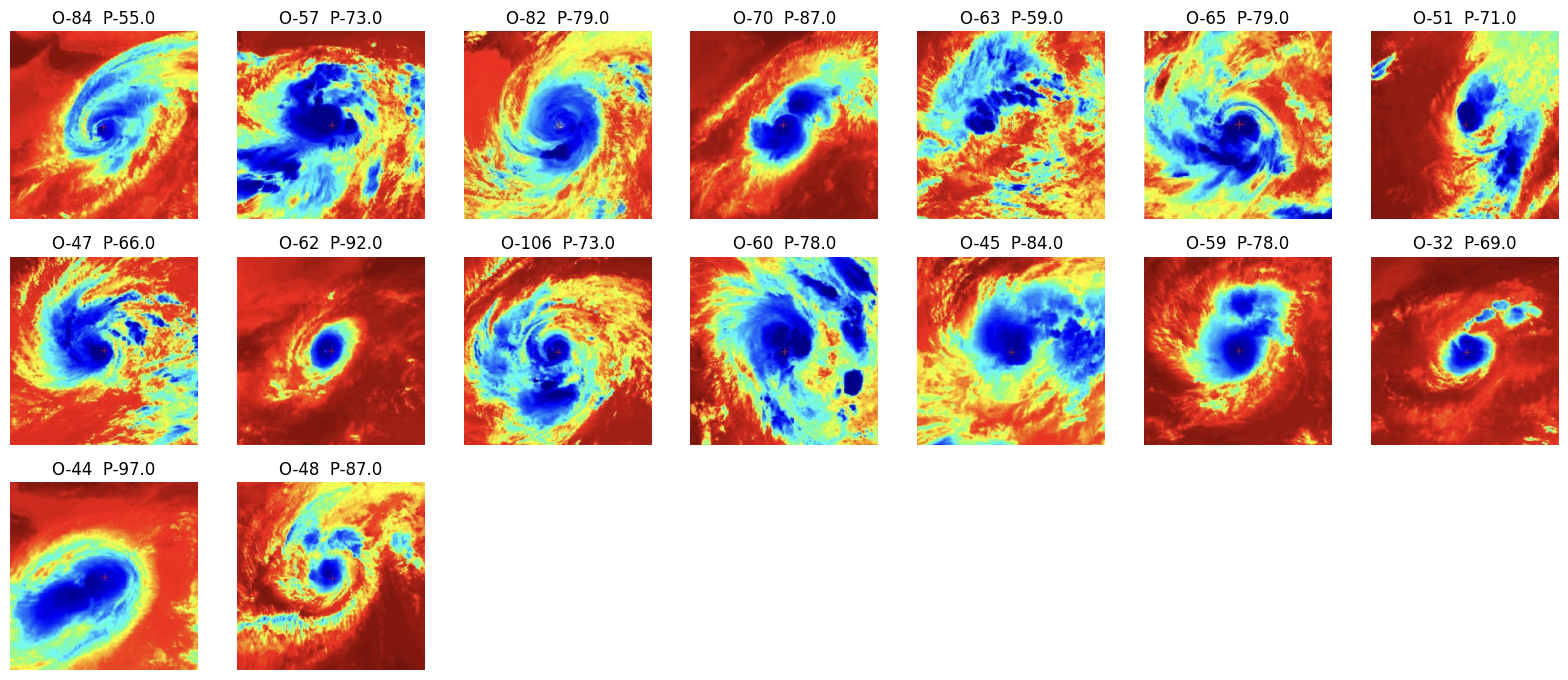

In [ ]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('best_model.h5') 
val_predictions = model.predict(train_data)
plt.figure(figsize=(20, 20))
for i in range(16):
    cur_img = train_data[0][0][i]
    ax = plt.subplot(7, 7, i + 1)
    plt.title("O-"+str(train_data[0][1][i])+"  P-"+str(val_predictions[i][0].round()))
    plt.imshow(cur_img)
    plt.axis("off")

7/7 [==============================] - 2s 149ms/step


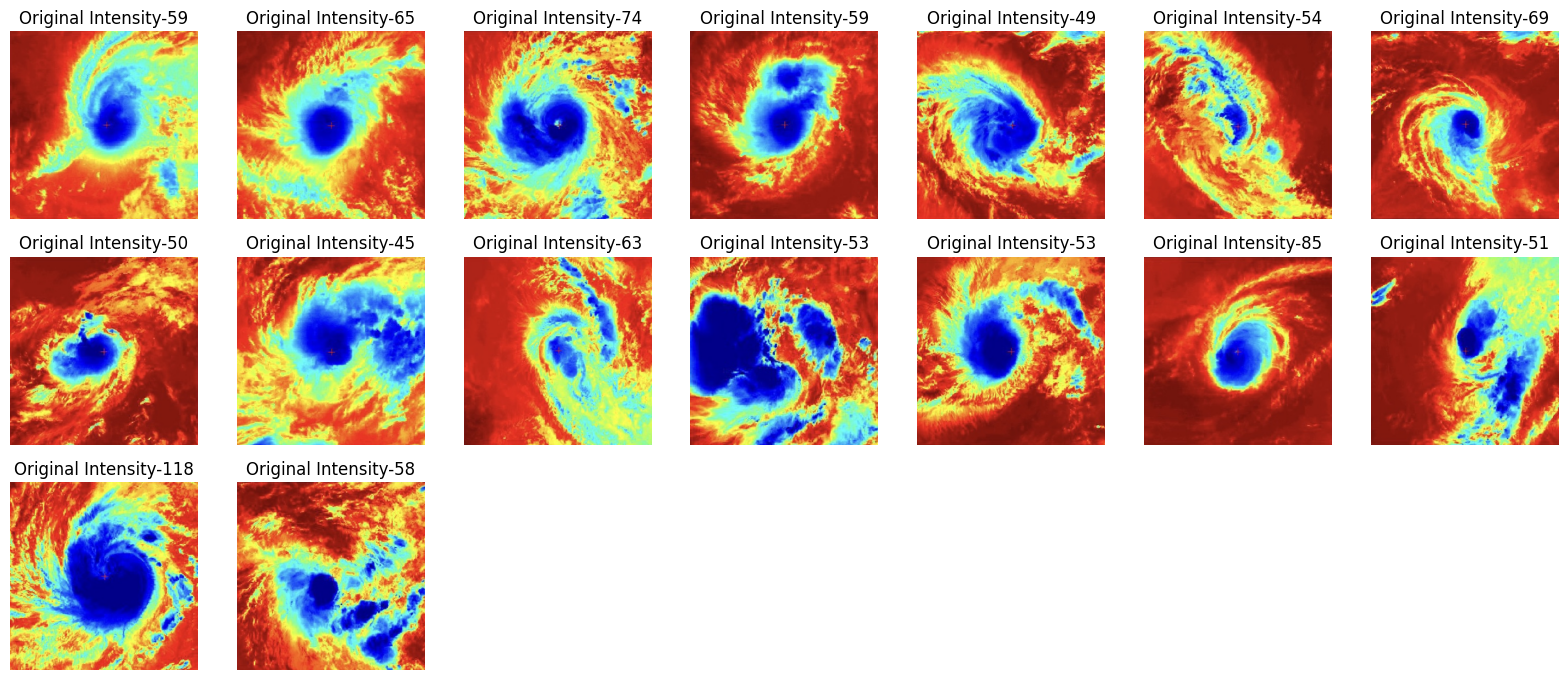

In [ ]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('best_model.h5') 
val_predictions = model.predict(train_data)
plt.figure(figsize=(20, 20))
for i in range(16):
    cur_img = train_data[0][0][i]
    ax = plt.subplot(7, 7, i + 1)
    plt.title("Original Intensity-"+str(train_data[0][1][i]))
    plt.imshow(cur_img)
    plt.axis("off")

In [ ]:
# import glob
# import matplotlib.image as mpimg
# paths = glob.glob("../input/insat3d-infrared-raw-cyclone-images-20132021/insat3d_for_reference_ds/CYCLONE_DATASET/*.jpeg")
# plt.figure(figsize=(20, 14))
# for i in range(4):
#     cur_img = mpimg.imread(paths[i]) 
#     ax = plt.subplot(1, 3, i + 1)
#     plt.imshow(cur_img.astype("uint8"))
#     plt.axis("off")

In [ ]:
# from sklearn.metrics import mean_absolute_error
# import numpy as np
# val_predictions = model.predict(val_data)

# # Calculate RMAE
# rmae = np.sqrt(mean_absolute_error(val_true_labels, val_predictions))

# # print(f'R2 Score on Validation Set: {r2}')
# # print(f'RMSE on Validation Set: {rmse}')
# print(f'RMAE on Validation Set: {rmae}')


2/2 [==============================] - 0s 119ms/step


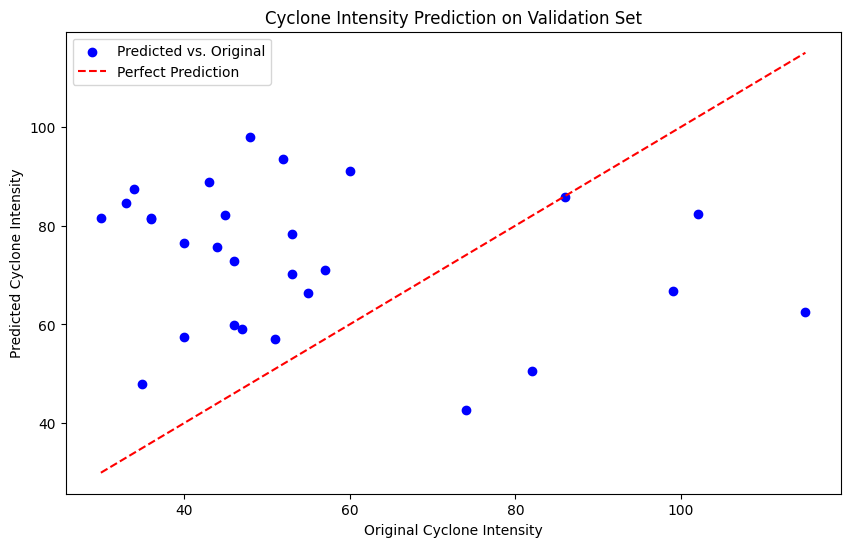

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
# model = load_model('cyclone_intensity_regression_model.h5')  # Load the saved model

# Predict on the validation set
val_predictions = model.predict(val_data)

# Extract original labels from the generator
val_original_labels = val_data.labels

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(val_original_labels, val_predictions, color='blue', label='Predicted vs. Original')
plt.plot([min(val_original_labels), max(val_original_labels)], [min(val_original_labels), max(val_original_labels)], linestyle='--', color='red', label='Perfect Prediction')
plt.xlabel('Original Cyclone Intensity')
plt.ylabel('Predicted Cyclone Intensity')
plt.title('Cyclone Intensity Prediction on Validation Set')
plt.legend()
plt.show()


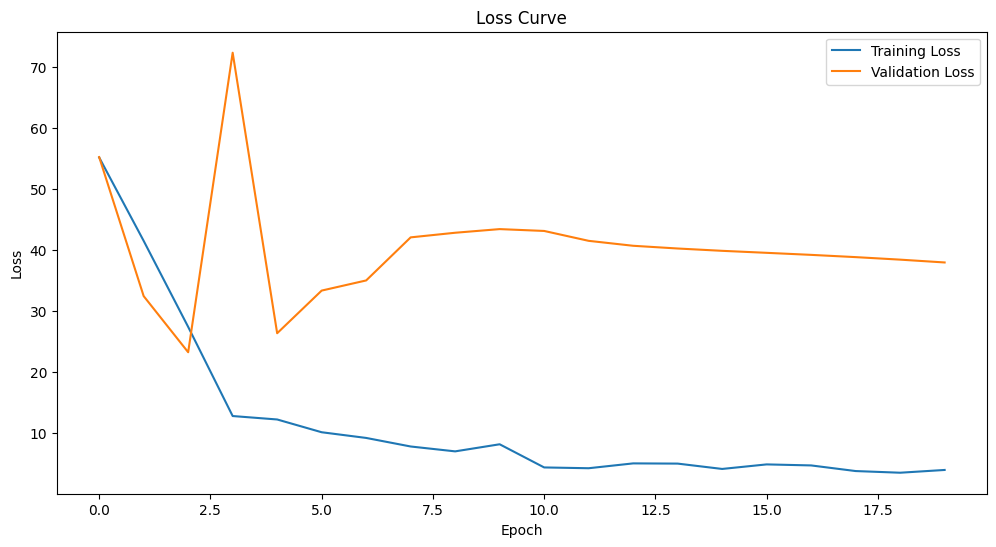

2/2 [==============================] - 0s 117ms/step


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error



# Plot the loss curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training Loss')
plt.plot(history.history['val_mae'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the validation set
val_predictions = model.predict(val_data)
val_true_labels = val_data.labels  # Assuming your data generator returns labels



In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(val_data)

# Flatten the predictions and true labels for calculation
val_predictions_flat = val_predictions.flatten()
true_labels_flat = val_df['label'].values  # Assuming 'label' is the column in your DataFrame containing true labels

# Calculate R^2 score
r2 = r2_score(true_labels_flat, val_predictions_flat)

# Calculate RMSE
rmse = mean_squared_error(true_labels_flat, val_predictions_flat, squared=False)

# Calculate MAE
mae = mean_absolute_error(true_labels_flat, val_predictions_flat)

# Print the metrics
print(f'R^2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


2/2 [==============================] - 0s 118ms/step
R^2 Score: -1.2587
RMSE: 33.1462
MAE: 29.5939


1/1 [==============================] - 0s 24ms/step


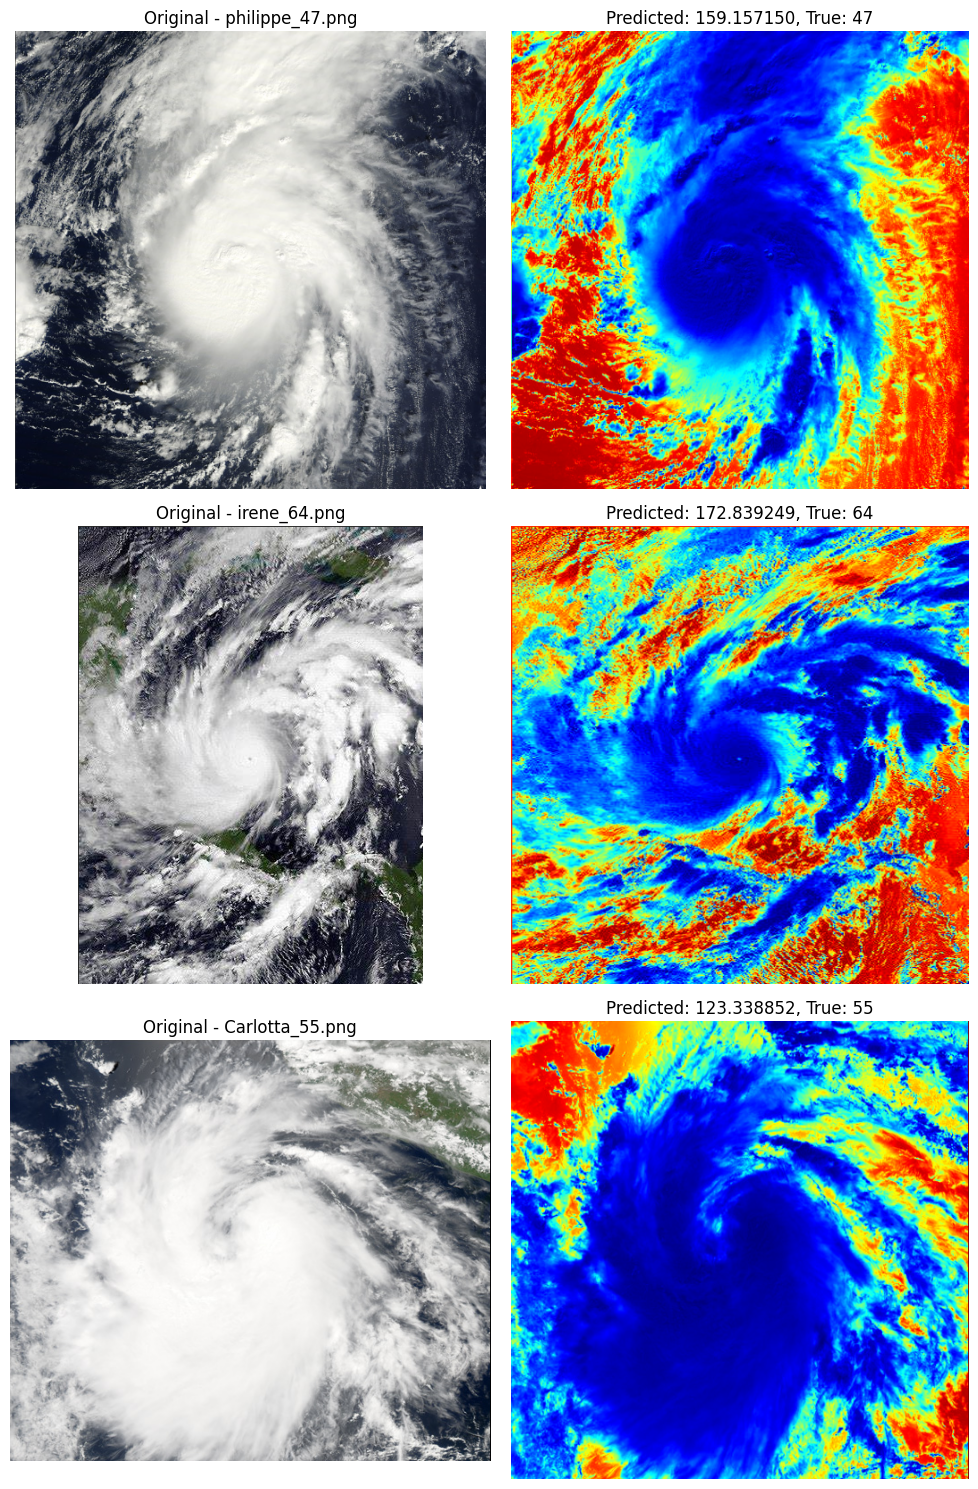

In [ ]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('cyclone_intensity_regression_model.h5')  # Update with the actual path

# Folder containing the images
image_folder = '/kaggle/input/mine-ds/'

# Function to preprocess an image as infrared-like
def preprocess_infrared_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (if needed)
    
    # Simulate infrared-like transformation (you may need to adjust this based on your data)
    infrared_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    infrared_image = cv2.applyColorMap(infrared_image, cv2.COLORMAP_JET)
    
    infrared_image = cv2.resize(infrared_image, (512, 512))  # Resize to match model input shape
    infrared_image = infrared_image / 255.0  # Normalize pixel values
    return np.expand_dims(infrared_image, axis=0)  # Add batch dimension

# Function to extract intensity from filename using regex
def extract_intensity(filename):
    match = re.search(r'_(\d+)', filename)
    return int(match.group(1)) if match else None

# Iterate through images, make predictions, and plot results
fig, axs = plt.subplots(nrows=len(os.listdir(image_folder)), ncols=2, figsize=(10, 5 * len(os.listdir(image_folder))))

for i, filename in enumerate(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, filename)
    
    # Preprocess image as infrared-like
    preprocessed_image = preprocess_infrared_image(image_path)

    # Make prediction
    predicted_intensity = model.predict(preprocessed_image)[0][0]

    # Extract true intensity from filename
    true_intensity = extract_intensity(filename)

    # Plot original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    axs[i, 0].imshow(original_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Original - {filename}")

    # Plot predicted image
    axs[i, 1].imshow(preprocessed_image[0], cmap='jet')  # Use cmap='jet' for infrared-like colormap
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Predicted: {predicted_intensity:2f}, True: {true_intensity}")

plt.tight_layout()
plt.show()


In [ ]:
# Load MobileNetV2 for classification
# def learning_rate_scheduler(epoch, lr):
#     if epoch < 1:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(512, 512, 3))

# Create a Sequential model
model = Sequential()

# Add the MobileNetV2 base model (excluding top layers)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(12, activation='relu'))  # Add a dense layer for better feature fusion
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    callbacks=[
        
        checkpoint_callback,
        early_stopping_callback,
        reduce_lr_callback,
        tensorboard_callback
    ]
)

# Save the model
model.save('cyclone_intensity_regression_model.h5')

87910968/87910968 [==============================] - 2s 0us/step
Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 3527.5801 - mae: 55.5286
Epoch 1: val_loss did not improve from 693.75110
7/7 [==============================] - 65s 4s/step - loss: 3527.5801 - mae: 55.5286 - val_loss: 1071.3484 - val_mae: 23.9251 - lr: 0.0010
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 2556.5510 - mae: 47.3055
Epoch 2: val_loss did not improve from 693.75110
7/7 [==============================] - 9s 1s/step - loss: 2556.5510 - mae: 47.3055 - val_loss: 2217.5093 - val_mae: 41.1660 - lr: 0.0010
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 1853.9258 - mae: 40.3674
Epoch 3: val_loss did not improve from 693.75110
7/7 [==============================] - 9s 1s/step - loss: 1853.9258 - mae: 40.3674 - val_loss: 2718.1211 - val_mae: 47.9787 - lr: 0.0010
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 1205.3710 - mae: 32.7797
Epoch 4: val

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 11s 2s/step - loss: 33.0406 - mae: 4.7123 - val_loss: 680.5961 - val_mae: 20.9265 - lr: 1.0000e-04
Epoch 18/25
7/7 [==============================] - ETA: 0s - loss: 45.0738 - mae: 4.9311
Epoch 18: val_loss improved from 680.59607 to 672.93652, saving model to best_model.h5
7/7 [==============================] - 11s 2s/step - loss: 45.0738 - mae: 4.9311 - val_loss: 672.9365 - val_mae: 20.5178 - lr: 1.0000e-04
Epoch 19/25
7/7 [==============================] - ETA: 0s - loss: 31.8002 - mae: 4.0171
Epoch 19: val_loss did not improve from 672.93652
7/7 [==============================] - 10s 1s/step - loss: 31.8002 - mae: 4.0171 - val_loss: 682.3871 - val_mae: 20.5186 - lr: 1.0000e-04
Epoch 20/25
7/7 [==============================] - ETA: 0s - loss: 27.3724 - mae: 4.2834
Epoch 20: val_loss improved from 672.93652 to 647.93817, saving model to best_model.h5
7/7 [==============================] - 11s 2s/step - loss: 27.3724 - mae: 4.2834 - val_loss: 64

In [4]:
# Load MobileNetV2 for classification
# def learning_rate_scheduler(epoch, lr):
#     if epoch < 1:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(512, 512, 3))

# Create a Sequential model
resmodel = Sequential()

# Add the MobileNetV2 base model (excluding top layers)
resmodel.add(base_model)
resmodel.add(GlobalAveragePooling2D())
resmodel.add(Dense(12, activation='relu'))  # Add a dense layer for better feature fusion
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(GlobalAveragePooling2D())
resmodel.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
resmodel.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = resmodel.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    callbacks=[
        
        checkpoint_callback,
        early_stopping_callback,
        reduce_lr_callback,
        tensorboard_callback
    ]
)

# Save the model
resmodel.save('cyclone_intensity_regression_model.h5')

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 2166.6270 - mae: 40.3252

KeyboardInterrupt: 

In [7]:
# Load MobileNetV2 for classification
# def learning_rate_scheduler(epoch, lr):
#     if epoch < 1:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(512, 512, 3))

# Create a Sequential model
model = Sequential()

# Add the MobileNetV2 base model (excluding top layers)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(12, activation='relu'))  # Add a dense layer for better feature fusion
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    callbacks=[
        
        checkpoint_callback,
        early_stopping_callback,
        reduce_lr_callback,
        tensorboard_callback
    ]
)

# Save the model
model.save('cyclone_intensity_regression_model.h5')

58889256/58889256 [==============================] - 192s 3us/step
Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 17360.5586 - mae: 91.8073 
Epoch 1: val_loss improved from inf to 3515.80029, saving model to best_model.h5
7/7 [==============================] - 114s 16s/step - loss: 17360.5586 - mae: 91.8073 - val_loss: 3515.8003 - val_mae: 55.0407 - lr: 0.0010
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 3999.8503 - mae: 59.3511 
Epoch 2: val_loss improved from 3515.80029 to 3138.09644, saving model to best_model.h5
7/7 [==============================] - 115s 16s/step - loss: 3999.8503 - mae: 59.3511 - val_loss: 3138.0964 - val_mae: 51.5026 - lr: 0.0010
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 2052.8425 - mae: 37.6317 
Epoch 3: val_loss improved from 3138.09644 to 1169.08826, saving model to best_model.h5
7/7 [==============================] - 117s 17s/step - loss: 2052.8425 - mae: 37.6317 - val_loss: 1169.0883 - val_mae:

In [ ]:
# Load MobileNetV2 for classification
# def learning_rate_scheduler(epoch, lr):
#     if epoch < 1:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(512, 512, 3))

# Create a Sequential model
Densemodel = Sequential()

# Add the MobileNetV2 base model (excluding top layers)
Densemodel.add(base_model)
Densemodel.add(GlobalAveragePooling2D())
Densemodel.add(Dense(12, activation='relu'))  # Add a dense layer for better feature fusion
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(GlobalAveragePooling2D())
Densemodel.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
Densemodel.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = Densemodel.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    callbacks=[
        
        checkpoint_callback,
        early_stopping_callback,
        reduce_lr_callback,
        tensorboard_callback
    ]
)

# Save the model
Densemodel.save('cyclone_intensity_regression_model.h5')

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import random

# Function to detect and draw ORB keypoints
def detect_and_draw(image_path, ax):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(image, None)
#     print(keypoints)

    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)

    # Display the image with keypoints
    ax.imshow(img_with_keypoints, cmap='gray')
    ax.axis('off')
    ax.set_title(image_path.split("/")[-1])

# Path to the directory containing images
image_directory = '/kaggle/input/insat3d-infrared-raw-cyclone-images-20132021/insat3d_raw_cyclone_ds/CYCLONE_DATASET_FINAL/'

# List all image files in the directory
all_image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith(('.jpg', '.png'))]

# Randomly select 4 images
selected_image_paths = random.sample(all_image_paths, min(4, len(all_image_paths)))

# Create a subplot of 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Loop through the selected images and detect keypoints
for i in range(min(4, len(selected_image_paths))):
    detect_and_draw(selected_image_paths[i], axs[i // 2, i % 2])

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(val_data)

# Flatten the predictions and true labels for calculation
val_predictions_flat = val_predictions.flatten()
true_labels_flat = val_df['label'].values  # Assuming 'label' is the column in your DataFrame containing true labels

# Calculate R^2 score
r2 = r2_score(true_labels_flat, val_predictions_flat)

# Calculate RMSE
rmse = mean_squared_error(true_labels_flat, val_predictions_flat, squared=False)

# Calculate MAE
mae = mean_absolute_error(true_labels_flat, val_predictions_flat)

# Print the metrics
print(f'R^2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
